In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile, lcl_sigma_bolton_simple
import os

import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Formatting figures info
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
leg_handlelength = 1.5

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
ds = {surf: xr.load_dataset(os.path.join(utils.out_dir, f"ds_tropics_{surf}.nc")) for surf in ['ocean', 'land']}

## Which $p_{FT}$ to choose
Here, 400hPa is better because more *convective* days according to error thresholding, and helps with topography issues i.e. more
regions have at least 100hPa from LCL to FT level.

In [5]:
aloft_p_size_thresh = 100*100    # Need at least 100hPa between LCL and FT level
for key in ds:
    # get rid of nan - due to different amounts of land at each lat
    n_days = (~np.isnan(ds[key].TREFHT)).sum(dim=['quant', 'lat', 'lon_sample']).values
    for p_ft in ds[key].p_ft:
        var1 = utils.get_valid_mask(ds[key].sel(p_ft=p_ft)).sum(dim=['quant', 'lat', 'lon_sample']).values / n_days * 100
        var2 = utils.get_valid_mask(ds[key].sel(p_ft=p_ft), aloft_p_size_thresh=aloft_p_size_thresh
                              ).sum(dim=['quant', 'lat', 'lon_sample']).values / n_days * 100
        print(key, float(p_ft/100), 'No lcl masking', np.round(var1, 1), 'With lcl masking', np.round(var2, 1))

ocean 400.0 No lcl masking [83.5 76. ] With lcl masking [83.5 76. ]
ocean 500.0 No lcl masking [73.4 60.7] With lcl masking [73.4 60.7]
ocean 700.0 No lcl masking [20.2 31.9] With lcl masking [20.2 31.9]
land 400.0 No lcl masking [85.4 82.2] With lcl masking [84.1 81.1]
land 500.0 No lcl masking [71.1 61.7] With lcl masking [65.7 56.8]
land 700.0 No lcl masking [ 9.1 13.6] With lcl masking [6.2 9.3]


### Fitting Error
Below we show that fitting error better for `mod_parcel` for aquaplanet but not land. Also, that `convflag` closer to 2 for aquaplanet indicating deep convection triggered more.

I use median and IQR for shading because `convflag` takes almost discrete values, so $\pm$ standard deviation shading looks way too big, given
that very few days have `convflag<1`. I.e. $\pm \sigma$ forces symmetric shading, when data is not symmetric about median.

In [6]:
p_ft_use = 400 * 100
for key in ds:
    ds[key] = ds[key].sel(p_ft=p_ft_use)

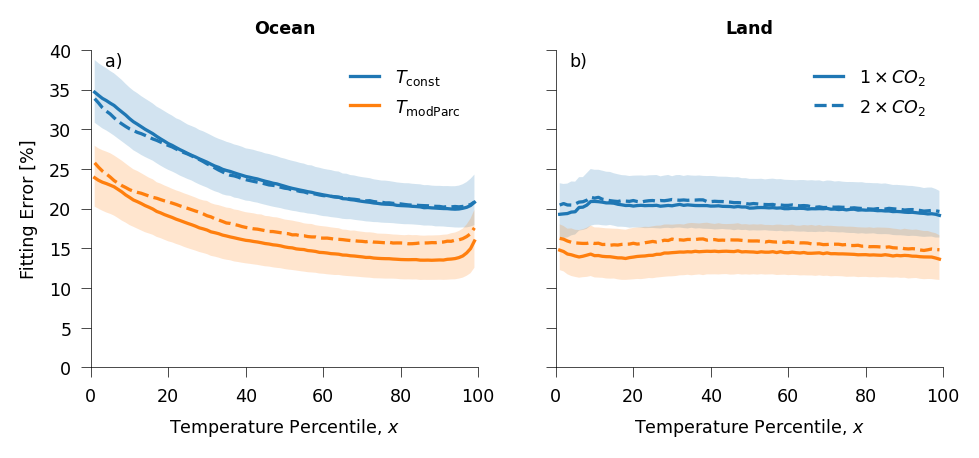

In [7]:
# lat_weights = np.cos(np.deg2rad(ds['land'].lat))
percentile_label = 'Temperature Percentile, $x$'
label_methods = {'const1': "$T_{\\text{const}}$", 'mod_parcel1': "$T_{\\text{modParc}}$"}

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for k, surf_use in enumerate(ds):
    ds_use = ds[surf_use]
    lat_weights = np.cos(np.deg2rad(ds_use.lat))
    ax[k].set_title(surf_use.capitalize(), fontweight='bold')
    ax[k].set_xlabel(percentile_label)
    for j in range(ds['ocean'].co2.size):
        for i, key in enumerate(['const1', 'mod_parcel1']):
            if k == 0:
                label_use = label_methods[key] if j == 0 else None
            else:
                label_use = f"${ds['ocean'].co2[j]:.0f} \\times CO_2$" if i == 0  else None
            var = np.abs(ds_use[f"{key}_error"].sum(dim='layer') / ds_use[f"{key}_integral"].sum(dim='layer') * 100).isel(co2=j)
            ax[k].plot(ds_use.quant, np.average(var.quantile(0.5, dim='lon_sample'), axis=1, weights=lat_weights), color=f"C{i}",
                          linestyle=[None, '--'][j], label=label_use)
            if j == 0:
                ax[k].fill_between(ds_use.quant, np.average(var.quantile(0.25, dim='lon_sample'), axis=1, weights=lat_weights),
                                      np.average(var.quantile(0.75, dim='lon_sample'), axis=1, weights=lat_weights), alpha=0.2,
                                      color=f"C{i}", edgecolor="none")

update_linewidth(fig, 1.5)
ax[0].set_ylim(0, 40)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Fitting Error [%]')
ax[0].legend(handlelength=leg_handlelength)
ax[1].legend(handlelength=leg_handlelength)
label_subplots(fig, ax.flatten(), pos_y=-1, box_alpha=0)
update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

### Valid days
Below I plot the days for which `mod_parcel` has lower error than 25% and thus days valid to consider convctive.

For southern hemisphere, the coldest days don't appear to be convective.

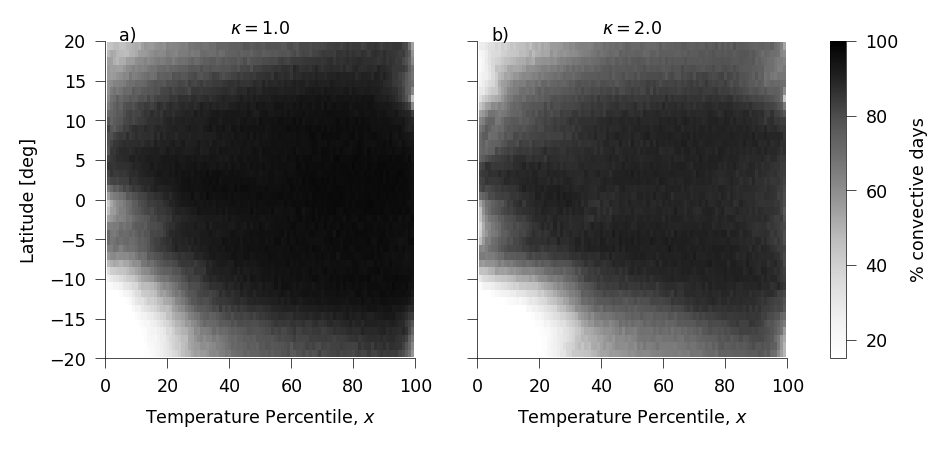

In [8]:
surf_plot = 'ocean'
error_thresh = 0.25
mask_fit = utils.get_valid_mask(ds[surf_plot], aloft_p_size_thresh=aloft_p_size_thresh)


var = (mask_fit.sum(dim='lon_sample') / ((~np.isnan(ds[surf_plot].TREFHT)).sum(dim='lon_sample')) * 100)

fig, ax = plt.subplots(1, ds[surf_plot].co2.size, sharey=True, sharex=True)
fig_resize(fig, width['two_col'])
for i in range(ds[surf_plot].co2.size):
    im = var.T.isel(co2=i).plot.imshow(ax=ax[i], cmap='Grays', vmin=15, vmax=100, add_colorbar=False)
    ax[i].set_xlabel(percentile_label)
    ax[i].set_title(f"$\kappa={var.co2[i]:.1f}$", y=0.97)
ax[0].set_ylim(-20, 20)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Latitude [deg]')
ax[1].set_ylabel('')
fig.colorbar(im, ax=ax, label='% convective days')
label_subplots(fig, ax, box_alpha=0, pos_y=5)
update_fontsize(fig, 10)
plt.show()
# isca_tools.savefig(fig)

## Where are non convective days?
The west coast of South America is non-convective, and colder. Probably due to trade winds bringing up cold air. In NH, land not configured in such a way that allows for this pattern i.e. more land in NH so warmer.

Slab ocean, so not due to ocean current stuff.

Not to do with El Nino, it is just the SST mean conditions in slab ocean simulations that this region is cold e.g. [Fig 1f in this paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010GL044888).

In CESM, a slab ocean model (SOM) is a simplified ocean component, often used to study atmospheric processes by excluding complex ocean dynamics like 3D currents, but it can still simulate upwelling, especially coastal upwelling driven by wind, by allowing cold, deep water (or just cooler surface water in the simplified case) to rise in regions like the eastern Pacific where trade winds push warm water away, impacting sea surface temperatures (SSTs) and climate feedbacks. While full ocean dynamics (like deep ocean heat uptake) are missing, CESM's slab version captures key air-sea interactions, allowing for investigations into how heat uptake patterns, such as in the Southern Ocean, teleconnect to tropical SSTs and influence climate.
https://share.google/aimode/yF7EKiTk3D6MjSQJA

In [9]:
ds2 = utils.load_ds('pre_industrial', 50,
                    ['TREFHT', 'const1_lapse', 'const1_error', 'const1_integral', 'mod_parcel1_error',
                     'mod_parcel1_integral', 'rh_REFHT', 'PS', 'LANDFRAC']).sel(p_ft=p_ft_use)
ds2 = ds2.load()

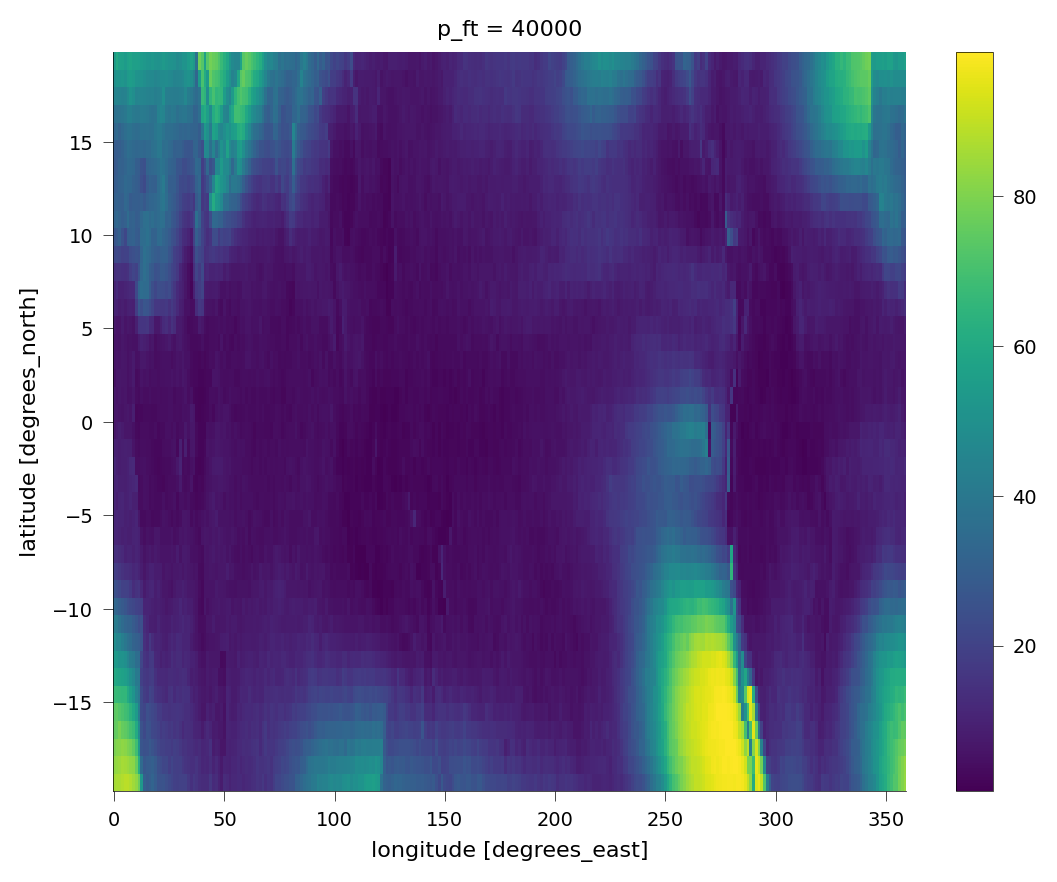

In [13]:
mask_spatial = get_valid_mask(ds2, aloft_p_size_thresh=aloft_p_size_thresh)
((~mask_spatial).sum(dim='sample')/ds2.sample.size*100).plot()